In [8]:
import os
import re

from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI

from agent.utils.loader import load_processed_data

_ = load_dotenv(find_dotenv())
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "self-correct"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["HTTP_PROXY"] = "http://127.0.0.1:7890"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:7890"

In [9]:
meta_info = {
	"dataset_name": 'ambig_qa',
	"mode": "self-improve",
	"base_mode": "cot",
	"model": "gpt-4o-mini-2024-07-18",
	"num_samples": -1,
	"top_p": 0.95,
	"temperature": 0,
	"seed": 42,
	"batch_size": 100
}
assert meta_info["mode"] == "self-improve"
assert meta_info["dataset_name"] in ["hotpot_qa", "trivia_qa", "ambig_qa"], "Invalid dataset name"

processed_data_path = f"../../../../data/processed_data/{meta_info['dataset_name']}.jsonl"

dataset = load_processed_data(dataset_name=meta_info["dataset_name"], file_path=processed_data_path)

model = ChatOpenAI(
	model_name="gpt-4o-mini",
	top_p=meta_info["top_p"],
	temperature=meta_info["temperature"],
	seed=meta_info["seed"],
	openai_api_base="https://api.chsdw.top/v1"
)

if meta_info["num_samples"] > 0:
	dataset = dataset.select(range(meta_info["num_samples"]))
print(dataset[2])

{'context': '', 'question': 'When was the first remote control tv invented?', 'answer': ['1950']}


In [10]:
from langgraph.graph import add_messages
from langchain_core.messages import BaseMessage
from typing import Sequence
from typing_extensions import TypedDict, Annotated
from langgraph.managed.is_last_step import RemainingSteps


class State(TypedDict):
	question: str
	guidance: str
	remaining_steps: RemainingSteps
	messages: Annotated[Sequence[BaseMessage], add_messages]
	initial_answer: str
	fusion: str
	prediction: str

In [20]:
from langchain_core.messages import AIMessage
from langchain_community.utilities.wikidata import WikidataAPIWrapper
from langgraph.prebuilt import ToolNode
from agent.utils.tools import GoogleSearchTool, GoogleKnowledgeGraphTool, WikidataTool, WikipediaTool, python_interpreter

google_search = GoogleSearchTool()
google_knowledge_graph = GoogleKnowledgeGraphTool()
wikidata = WikidataTool(api_wrapper=WikidataAPIWrapper())
wikipedia = WikipediaTool()
tools = [google_search, google_knowledge_graph, wikipedia, wikidata, python_interpreter]

model_with_tools = model.bind_tools(tools)

In [27]:
model_with_tools.invoke(input="list your tool set.")

AIMessage(content="I have access to the following tools:\n\n1. **Google Search**: A search engine to find current events and information by querying specific topics.\n  \n2. **Google Knowledge Graph**: This tool provides information about people, places, things, and concepts from Google's Knowledge Graph.\n\n3. **Wikipedia**: A wrapper around Wikipedia for general queries about various subjects, including people, historical events, and more.\n\n4. **Wikidata**: A wrapper around Wikidata that provides structured data about entities, including their demographics, education, notable works, and affiliations.\n\n5. **Python Interpreter**: An environment for executing Python code, which can perform mathematical operations and return results.\n\n6. **Multi Tool Use**: A function that allows simultaneous use of multiple tools for efficiency.\n\nIf you have any specific queries or tasks, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_toke

In [28]:
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate

guidance_prompt = hub.pull("arietem/guidance")
guidance_generator = guidance_prompt | model_with_tools.with_structured_output(method="json_mode")


async def guidance_node(state: State) -> State:
	assert state["question"] is not None, "Question is required"
	question:str = state["question"]
	guidance:AIMessage = await guidance_generator.ainvoke(input={"question": question})
	state["guidance"] = guidance.content
	return state

In [30]:
guidance_prompt.invoke(input={"question": "Who is older, Annie Morton or Terry Richardson?"})


ChatPromptValue(messages=[SystemMessage(content='> Thinking\n**Crafting system prompts**\nI\'m engaged in creating a precise system prompt to guide a large language model, reflecting on the task description or existing prompt for effective guidance.\n**Designing precise instructions**\nI’m crafting a detailed system prompt for a language model, ensuring it aligns effectively with the task description or existing prompt.\n**Crafting effective guidance**\nI\'m focused on generating a crafted prompt to steer a language model, ensuring it aligns accurately with the provided task description or existing prompt.\n**Creating tailored guidance**\nI’m set to design a detailed system prompt for a language model, ensuring it captures and effectively follows the task description or existing prompt provided.\n**Crafting precise guidance**\nI’m crafting a detailed system prompt to ensure a language model effectively follows a task description or existing prompt. This involves careful consideration o

In [7]:
model_with_tools.invoke(input="list your tool set.")

AIMessage(content='I have access to the following tools:\n\n1. **Google Search**: A search engine to find current events and information by querying specific topics.\n  \n2. **Google Knowledge Graph**: A tool to get structured information about people, places, things, and concepts.\n\n3. **Wikipedia**: A wrapper around Wikipedia to look up general information about various subjects.\n\n4. **Wikidata**: A wrapper around Wikidata to access structured data about entities, including demographics, education, notable works, and more.\n\n5. **Python Interpreter**: A code execution environment to perform calculations and numerical operations using Python.\n\nThese tools allow me to gather information, perform searches, and execute code as needed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 142, 'prompt_tokens': 537, 'total_tokens': 679, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 're

In [6]:
from typing import Literal

critique_prompt = ChatPromptTemplate.from_messages([
	(
		"system",
		"You are a reactive agent. Given a question or problem, your job is to select the appropriate tools to answer the question or solve the problem. You should consider the guidance provided by the question planner and error prone points identifier, and the tool results are reliable. If you find the answer from the tool results, you should provide the answer."
	),
	(
		"user",
		"Question: {question}"
		"Guidance: {guidance}"
	)
])

async def critique_node(state: State):
	assert state["question"] is not None, "Question is required"
	assert state["guidance"] is not None, "Guidance is required"
	question:str = state["question"]
	guidance:str = state["guidance"]
	messages:list[BaseMessage] = []
	if len(state["messages"]) == 0:
		messages = critique_prompt.invoke(input={"question": question, "guidance": guidance}).to_messages()
		critique:AIMessage = await model_with_tools.ainvoke(input=messages)
		messages.append(critique)
	else:
		critique:AIMessage = await model_with_tools.ainvoke(input=state["messages"])
		messages.append(critique)
	return {"messages": messages}

# Define our tool node
tool_node = ToolNode(tools)
# Define our tool node


fusion_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system",
			"You are a fusion agent. Given a question or problem and based on the critique process, your job is to fuse the tool results and then revise your final answer. "
			"Your response should contains two part, the first part is the fusion of the Revising Process and the second part is the final answer. In the fusion part, you should extract the information from the tool result and also indicate how you obtained the information.(which tool, which part of the result) In the final answer, "
			"do not include any explanations, context, or additional information. Just focus on delivering the exact answer as concisely as possible!!! "
			"There is no need to answer the question in the form of a complete sentence, just provide the answer in the form of a noun, time, entity, single number, yes or no, etc."
		),
		(
			"placeholder",
			"{messages}"
		),
		(
			"user",
			"Question: {question}"
			"Now based on the previous information, please fuse the tool results and revise your answer. Use the XML tag <fusion></fusion> to indicate the fusion part and <answer></answer> to indicate the final answer part. Do not provide multiple answers in the final answer to increase your chances of getting the answer right. You need to give the answer you think is the most appropriate."
		)
	])
fusion_generator = fusion_prompt | model

async def fusion_node(state: State) -> State:
	assert state["question"] is not None, "Question is required"
	assert state["guidance"] is not None, "Guidance is required"
	critique_messages:Sequence[BaseMessage] = state["messages"][1:]
	response:AIMessage = await fusion_generator.ainvoke(input={"messages": critique_messages, "question": state["question"]})
	fusion_matches = re.findall(r"<fusion>(.*?)</fusion>", response.content, re.DOTALL)
	answer_matches = re.findall(r"<answer>(.*?)</answer>", response.content, re.DOTALL)
	if fusion_matches:
		state["fusion"] = fusion_matches[0]
	else:
		state["fusion"] = response.content
	if answer_matches:
		state["prediction"] = answer_matches[0]
	else:
		state["prediction"] = "None"

	return state

# Define the conditional edge that determines whether to continue or not
def should_continue(state: State) -> Literal["fuse", "tools"]:
	messages = state["messages"]
	last_message = messages[-1]

	# If there is no function call, then we finish
	if last_message.tool_calls:
		return "tools"
	# Otherwise if there is, we continue
	else:
		return "fuse"

def tools_router(state: State) -> Literal["fuse",  "critique"]:
	if state["remaining_steps"] <= 3:
		return "fuse"
	else:
		return "critique"

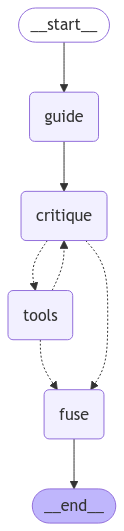

In [7]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)
workflow.add_node("guide", guidance_node)
workflow.add_node("critique", critique_node)
workflow.add_node("tools", tool_node)
workflow.add_node("fuse", fusion_node)

workflow.set_entry_point("guide")
workflow.add_edge("guide", "critique")
workflow.add_conditional_edges("tools", tools_router)
workflow.add_conditional_edges("critique", should_continue)
workflow.add_edge("fuse", "__end__")

app = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [12]:
inputs = {**dataset[5], "messages": []}
async for event in app.astream(inputs):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'question': 'When was the first airline meal served during a flight?', 'messages': [], 'guidance': 'Step 1: Research the history of commercial aviation to identify the timeline of airline services, specifically focusing on meal services.  \n- Error-prone points: Potential confusion about distinguishing between different types of aviation services (e.g., military vs. commercial) and varying definitions of what constitutes an "airline meal".\n\nStep 2: Look for sources or literature that detail the first instances of in-flight meal service. This may include articles, books on aviation history, or credible aviation websites.  \n- Error-prone points: Relying on non-reputable sources or misinterpreting anecdotal evidence as historical fact.\n\nStep 3: Verify the information gathered by cross-referencing multiple reliable sources to confirm the date and details of the first airline meal served.  \n- Error-prone points: Misunderstanding dates or events due to different interpretations or con

In [13]:
from tqdm.asyncio import tqdm_asyncio, tqdm
import os
import json
import logging
import nest_asyncio

# 配置logger
logging.basicConfig(
    level=logging.ERROR,  # 设置日志级别
    format='%(asctime)s - %(levelname)s - %(message)s',  # 设置日志格式
    handlers=[
        logging.FileHandler("inference.log"),  # 将日志输出到文件
        logging.StreamHandler()  # 也输出到控制台
    ]
)

logger = logging.getLogger("InferenceLogger")

nest_asyncio.apply()
results = []
batch_size = 100
save_results_path = f"../../../output/inference/{meta_info['model']}/{meta_info['dataset_name']}/{meta_info['mode']}/with_question_before_fusion_{meta_info['base_mode']}_num_samples_{meta_info['num_samples']}_top_p_{meta_info['top_p']}_temperature_{meta_info['temperature']}_seed_{meta_info['seed']}.jsonl"
# save_results_path = f"../../../output/inference/{meta_info['model']}/{meta_info['dataset_name']}/{meta_info['mode']}/{meta_info['base_mode']}_num_samples_223_top_p_{meta_info['top_p']}_temperature_{meta_info['temperature']}_seed_{meta_info['seed']}.jsonl"

async def process(item):
    try:
        state = await app.ainvoke({**item, "messages": []}, config={"recursion_limit": 18})
        state["messages"] = [message.pretty_repr() for message in state["messages"]]
        logger.info(f"Processed item: {item}")
        return {**item, **state}
    except Exception as e:
        logger.error(f"Error processing item: {item}. Error: {e}")
        return {**item, "prediction": "None"}

async def self_improve_inference() -> None:
    error_indices = []  # 用于记录包含 "ERROR" 的条目索引

    # 读取已有结果或初始化文件
    if os.path.exists(save_results_path):
        logger.info(f"Loading existing results from {save_results_path}")
        with open(save_results_path, 'r') as file:
            for idx, line in enumerate(file):
                result = json.loads(line)
                results.append(result)
                # 检查是否存在 "prediction: ERROR"
                if "None" == result.get("prediction"):
                    error_indices.append(idx)
    else:
        folder_path = os.path.dirname(save_results_path)
        os.makedirs(folder_path, exist_ok=True)
        logger.info(f"Created directory for results: {folder_path}")

    # 重新推理错误的数据
    if error_indices:
        logger.warning(f"Found {len(error_indices)} ERROR entries. Retrying inference...")
        error_data = [dataset[idx] for idx in error_indices]
        new_results = await tqdm_asyncio.gather(*(process(item) for item in error_data))
        # 更新原始结果
        for i, new_result in zip(error_indices, new_results):
            results[i] = new_result

    # 使用tqdm进度条显示进度，设置desc为提示信息
    bar = tqdm(total=dataset.num_rows, desc="Processing batches", position=0, dynamic_ncols=True)

    for idx in range(len(results), dataset.num_rows, batch_size):
        batch = dataset.select(range(idx, min(idx + batch_size, dataset.num_rows)))
        batch_results = await tqdm_asyncio.gather(*(process(item) for item in batch))
        results.extend(batch_results)

        # 更新进度条，进度条更新为当前批次的长度
        bar.update(batch_size)
        logger.info(f"Processed batch starting at index {idx}")

        # 保存结果
        with open(save_results_path, 'qa') as file:
            for result in results:
                file.write(json.dumps(result) + "\n")
        logger.info(f"Saved results to {save_results_path}")

    bar.close()  # 完成处理后关闭进度条

In [14]:
await self_improve_inference()

 44%|████▍     | 44/100 [01:00<02:43,  2.92s/it]2025-01-14 16:03:20,512 - ERROR - Error processing item: {'context': '', 'question': 'What was the first cartoon show on tv?', 'answer': ['Crusader Rabbit']}. Error: Error code: 400 - {'error': {'message': 'sensitive words: 8964 (request id: 202501141603204424052921mSMYdig)', 'type': 'new_api_error', 'param': '', 'code': 'sensitive_words_detected'}}

  0%|          | 0/100 [00:00<?, ?it/s]2025-01-14 16:16:41,111 - ERROR - Error processing item: {'context': '', 'question': 'What are the 2 parks at euro disney?', 'answer': ['Parc Walt Disney Studios', 'Walt Disney Studios Park', 'originally Euro Disneyland Park', 'Disneyland Park']}. Error: Error code: 400 - {'error': {'message': 'sensitive words: 8964 (request id: 20250114161640977931121GWhRfHx4)', 'type': 'new_api_error', 'param': '', 'code': 'sensitive_words_detected'}}

 30%|███       | 30/100 [00:36<02:07,  1.82s/it]2025-01-14 16:36:14,945 - ERROR - Error processing item: {'context': '